In [16]:
review_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json'
business_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json'
user_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/yelp_dataset/yelp_academic_dataset_user.json'
checkin_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/yelp_dataset/yelp_academic_dataset_checkin.json'
tip_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/yelp_dataset/yelp_academic_dataset_tip.json'

----
# Sentiment Analysis and Topic Modeling for Yelp Business Success
# Author: Farzam Afzal
----

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
#import pyLDAvis.sklearn

# BERT Sentiment Analysis
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax

In [29]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Setting paths for data files
#review_path = 'yelp_academic_dataset_review.json'  # Update with actual path
#business_path = 'yelp_academic_dataset_business.json'  # Update with actual path

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

In [30]:
# Function for reading JSON files line by line
def read_json(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Loading a sample of review data for development (adjust max_records for full implementation)
print("Loading review data...")
review_df = read_json(review_path, max_records=50000)  # May use a larger sample for actual implementation
print(f"Loaded {len(review_df)} reviews.")

# Load business data to join with reviews
print("Loading business data...")
business_df = read_json(business_path)
print(f"Loaded {len(business_df)} businesses.")

Loading review data...


50000it [00:01, 32735.88it/s]


Loaded 50000 reviews.
Loading business data...


150346it [00:04, 31515.38it/s] 


Loaded 150346 businesses.


In [31]:
# Joining business categories with reviews for context-aware analysis
review_business_df = review_df.merge(
    business_df[['business_id', 'categories']], 
    on='business_id', 
    how='left'
)


- Text Preprocessing Functions
--------------------------------------------------

In [32]:
def preprocess_text(text):
    """Clean and normalize text data for NLP tasks."""
    if not isinstance(text, str):
        return ""
    
    # Conversion to lowercase
    text = text.lower()
    
    # Removal of HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Removal of URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Removal of special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Removal of extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text."""
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Removing stopwords and lemmatizing
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens


- BERT-based Sentiment Analysis
--------------------------------------------------

In [33]:
class BERTSentimentAnalyzer:
    def __init__(self):
        # Load pre-trained BERT model for sentiment analysis
        self.tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.sentiment_pipeline = pipeline("sentiment-analysis", 
                                           model=self.model, 
                                           tokenizer=self.tokenizer)
        
    def analyze_sentiment(self, text, max_length=512):
        """
        Analyze sentiment of text using BERT.
        Returns:
            - sentiment_score: Normalized score between 0 and 1
            - sentiment_label: One of 'negative', 'neutral', or 'positive'
        """
        # Truncates text to max_length
        text = text[:max_length]
        
        # Gets sentiment prediction
        result = self.sentiment_pipeline(text)[0]
        
        # Extracts label and score
        raw_score = int(result['label'].split(' ')[0])
        
        # Normalizes to 0-1 range (model returns scores 1-5)
        normalized_score = (raw_score - 1) / 4
        
        # Determines sentiment label
        if normalized_score < 0.4:
            sentiment_label = 'negative'
        elif normalized_score > 0.6:
            sentiment_label = 'positive'
        else:
            sentiment_label = 'neutral'
            
        return normalized_score, sentiment_label
    
    def analyze_batch(self, texts, batch_size=32):
        """Analyze sentiment for a batch of texts."""
        sentiment_scores = []
        sentiment_labels = []
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            results = []
            
            for text in tqdm(batch, desc=f"Processing batch {i//batch_size + 1}"):
                if isinstance(text, str) and len(text.strip()) > 0:
                    score, label = self.analyze_sentiment(text)
                else:
                    score, label = 0.5, 'neutral'  # Default for empty text
                
                results.append((score, label))
            
            batch_scores, batch_labels = zip(*results)
            sentiment_scores.extend(batch_scores)
            sentiment_labels.extend(batch_labels)
        
        return sentiment_scores, sentiment_labels


- Topic Modeling with LDA
--------------------------------------------------

In [34]:
class ReviewTopicModeler:
    def __init__(self, n_topics=10, max_features=5000, min_df=5, max_df=0.8):
        self.n_topics = n_topics
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        
        # Initializes vectorizer
        self.vectorizer = CountVectorizer(
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english'
        )
        
        # Initializes LDA model
        self.lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=10,
            learning_method='online'
        )
        
        self.feature_names = None
        self.document_topics = None
        
    def fit_transform(self, texts):
        """Fit LDA model and transform texts to topic distributions."""
        # Creates document-term matrix
        print("Creating document-term matrix...")
        dtm = self.vectorizer.fit_transform(texts)
        self.feature_names = self.vectorizer.get_feature_names_out()
        self.texts = texts  # Store the texts as an instance variable
        
        # Fits LDA model
        print(f"Fitting LDA model with {self.n_topics} topics...")
        self.document_topics = self.lda_model.fit_transform(dtm)
        
        return self.document_topics
    
    def transform(self, texts):
        """Transform new texts to topic distributions."""
        dtm = self.vectorizer.transform(texts)
        return self.lda_model.transform(dtm)
    
    def get_topic_words(self, n_words=10):
        """Get the top words for each topic."""
        topic_words = []
        
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_word_indices = topic.argsort()[:-n_words-1:-1]
            top_words = [self.feature_names[i] for i in top_word_indices]
            topic_words.append(top_words)
            
        return topic_words
    
    def visualize_topics(self, dtm=None):
        """Create an interactive visualization of topics."""
        if dtm is None and hasattr(self, 'texts'):
            # Uses the document-term matrix from fit_transform
            dtm = self.vectorizer.transform(self.texts)
        elif dtm is None:
            print("Error: No texts available for visualization")
            return None
        
        # Convert the LDA model to the format required by pyLDAvis
        topic_term_dists = self.lda_model.components_ / self.lda_model.components_.sum(axis=1)[:, np.newaxis]
        doc_topic_dists = self.document_topics
        vocab = self.vectorizer.get_feature_names_out()
        term_frequency = np.asarray(dtm.sum(axis=0)).ravel()
        
        # Calculate document lengths (sum of term frequencies for each document)
        doc_lengths = np.asarray(dtm.sum(axis=1)).ravel()
        
        # Use the prepare function with all required parameters
        vis_data = pyLDAvis.prepare(
            topic_term_dists=topic_term_dists,
            doc_topic_dists=doc_topic_dists,
            doc_lengths=doc_lengths,
            vocab=vocab,
            term_frequency=term_frequency,
            mds='tsne'
        )
        
        # Saves visualization to HTML
        pyLDAvis.save_html(vis_data, 'lda_visualization.html')
        print("Visualization saved to 'lda_visualization.html'")
        
        return vis_data


- Main Analysis Pipeline
--------------------------------------------------

Sampling 10000 reviews for analysis...
Preprocessing review text...
After preprocessing, 9997 reviews remain.
Initializing BERT sentiment analyzer...


Device set to use mps:0


Analyzing sentiment...


Processing batch 313: 100%|██████████| 13/13 [00:00<00:00, 14.43it/s]


Initializing topic modeler...
Creating document-term matrix...
Fitting LDA model with 10 topics...

Topic Keywords:
Topic 0: great, room, staff, hotel, car, nice, new, stay, time, clean, friendly, work, day, service, job
Topic 1: great, good, food, place, burger, service, delicious, cheese, really, chicken, fries, shrimp, pork, definitely, beer
Topic 2: bar, place, like, coffee, wine, just, really, fun, area, beer, parking, people, music, good, selection
Topic 3: time, drive, location, cafe, paid, kids, view, pool, healthy, available, delivery, floor, takes, play, located
Topic 4: ordered, time, food, just, order, came, got, like, didnt, table, sandwich, wasnt, good, wait, chicken
Topic 5: food, good, place, service, great, restaurant, nice, pretty, breakfast, really, staff, friendly, little, like, price
Topic 6: cream, ice, delicious, chocolate, amazing, sweet, tea, cake, bread, try, fresh, coffee, new, dessert, best
Topic 7: pizza, place, like, good, love, fresh, sushi, rice, im, chi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Visualization saved to 'lda_visualization.html'


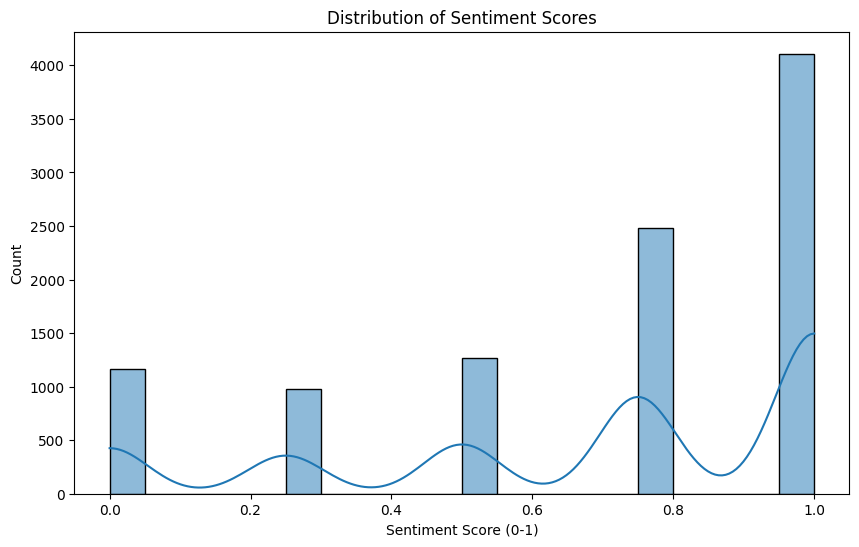

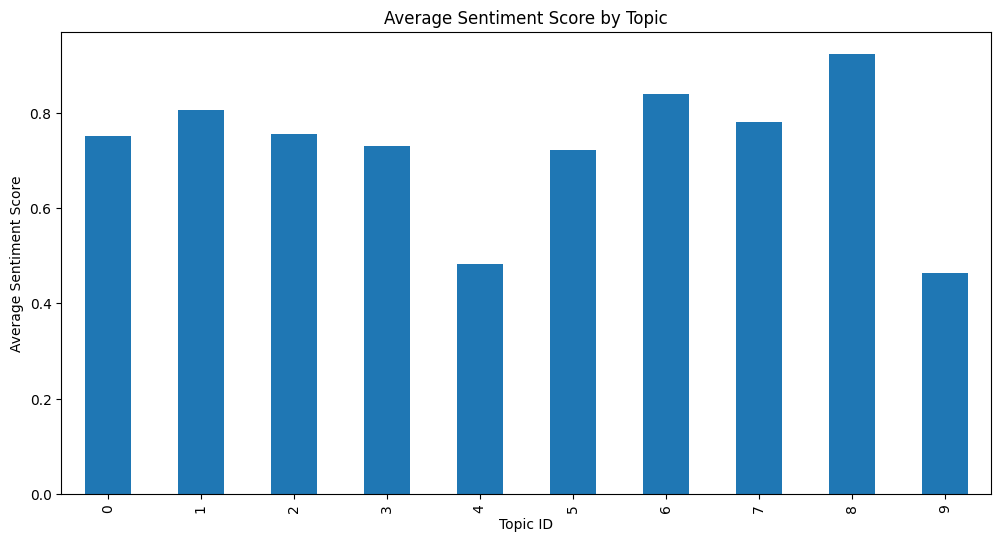

In [35]:
def main():
    # Sampling a subset of reviews for development (remove this limit for full implementation)
    sample_size = 10000
    print(f"Sampling {sample_size} reviews for analysis...")
    review_sample = review_business_df.sample(sample_size, random_state=42)
    
    # Preprocessing review text
    print("Preprocessing review text...")
    review_sample['processed_text'] = review_sample['text'].apply(preprocess_text)
    
    # Filters out empty reviews after preprocessing
    review_sample = review_sample[review_sample['processed_text'].str.len() > 20]
    print(f"After preprocessing, {len(review_sample)} reviews remain.")
    
    # Initializes BERT sentiment analyzer
    print("Initializing BERT sentiment analyzer...")
    sentiment_analyzer = BERTSentimentAnalyzer()
    
    # Analyzes sentiment for reviews
    print("Analyzing sentiment...")
    sentiment_scores, sentiment_labels = sentiment_analyzer.analyze_batch(
        review_sample['processed_text'].tolist()
    )
    
    # Adds sentiment analysis results to dataframe
    review_sample['sentiment_score'] = sentiment_scores
    review_sample['sentiment_label'] = sentiment_labels
    
    # Initializes topic modeler
    print("Initializing topic modeler...")
    topic_modeler = ReviewTopicModeler(n_topics=10)
    
    # Fits topic model and get topic distributions
    topic_distributions = topic_modeler.fit_transform(review_sample['processed_text'])
    
    # Adds dominant topic for each review
    dominant_topics = np.argmax(topic_distributions, axis=1)
    review_sample['dominant_topic'] = dominant_topics
    
    # Gets top words for each topic
    topic_words = topic_modeler.get_topic_words(n_words=15)
    
    # Prints topic keywords
    print("\nTopic Keywords:")
    for i, words in enumerate(topic_words):
        print(f"Topic {i}: {', '.join(words)}")
        
    # Analyzes relationship between sentiment and topics
    topic_sentiment = review_sample.groupby('dominant_topic')['sentiment_score'].mean()
    
    print("\nAverage Sentiment Score by Topic:")
    print(topic_sentiment)
    
    # Analyzes relationship between topics and business stars
    topic_stars = review_sample.groupby('dominant_topic')['stars'].mean()
    
    print("\nAverage Star Rating by Topic:")
    print(topic_stars)
    
    # Saves processed data for further analysis
    print("Saving processed data...")
    review_sample.to_csv('processed_reviews_with_nlp.csv', index=False)
    
    # Creates sentiment score distribution by business
    business_sentiment = review_sample.groupby('business_id')['sentiment_score'].agg(['mean', 'median', 'count'])
    business_sentiment = business_sentiment.rename(columns={'mean': 'avg_sentiment', 'count': 'review_count'})
    
    # Merges with business data
    business_nlp_df = business_df.merge(business_sentiment, on='business_id', how='inner')
    
    # Saves business-level sentiment data
    business_nlp_df.to_csv('business_sentiment_data.csv', index=False)
    
    print("Analysis complete. Results saved to CSV files.")
    
    # Creates visualizations
    plt.figure(figsize=(10, 6))
    sns.histplot(review_sample['sentiment_score'], bins=20, kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score (0-1)')
    plt.ylabel('Count')
    plt.savefig('sentiment_distribution.png')
    
    # Topic-Sentiment relationship visualization
    plt.figure(figsize=(12, 6))
    topic_sentiment.plot(kind='bar')
    plt.title('Average Sentiment Score by Topic')
    plt.xlabel('Topic ID')
    plt.ylabel('Average Sentiment Score')
    plt.savefig('topic_sentiment.png')
    
    # Generating interactive LDA visualization
    topic_modeler.visualize_topics()

if __name__ == "__main__":
    main()

----
# Data extraction and Modelling
----

# Clean and Scale Data 

### Contribution and details
- I adopted Jennifer Ngyuen's method of importing data and Adefemi Abimbola's feature extraction and engineering. I ran into problems with accessing information as the way data as accessed and saved differed (JSON -> dataframe vs. csv -> dataframe); it caused some complications when attempting to access nested information like dictionaries. Hopefully everything is easily translatable and we don't run into problems. 
- I also ran into problems with the size of the data. I did what Jennifer did in her .ipynb, which was use a sample size dataset. Hopefully the techniques are still effective when applied to entire dataset (if that is what we are doing). 
- I added many more columns that we may be able to use. If not we can just discard
- I scaled continous variables 

In [25]:
# Import libraries and load datasets
import json
import csv
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # For progress bars
from datetime import datetime # To get hours open
from sklearn.preprocessing import StandardScaler #To scale continous features 
import ast

In [220]:
#Reading and saving datasets 

#Paths to load datasets
#business_path = 'yelp_academic_dataset_business.json'
#review_path = 'yelp_academic_dataset_review.json'
#user_path = 'yelp_academic_dataset_user.json'
#checkin_path = 'yelp_academic_dataset_checkin.json'
#tip_path = 'yelp_academic_dataset_tip.json'

#Reading JSON files 
def read_json(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)
    
# Removed 'max_records' for business and users since we have to clean it
# Saved 'max_records' for others for faster processing but can remove when utilizing entire dataset
#business = read_json(business_path)
business = pd.read_csv('business_sentiment_data.csv')
review = pd.read_csv('processed_reviews_with_nlp.csv')
user = read_json(user_path, max_records=10000)
checkin = read_json(checkin_path, max_records=10000)
tip = read_json(tip_path, max_records=10000)

10000it [00:02, 4769.00it/s]
10000it [00:00, 89511.14it/s]
10000it [00:00, 257227.73it/s]


In [221]:
# Aggregating the dataset into a master dataset
# master dataset created each row represents one review

business.rename(columns={'name': 'business_name',
                         'address': 'business_address',
                         'city': 'business_city',
                         'stars': 'business_stars',
                         'review_count_x':'business_review_count_x',
                         'review_count_y':'business_review_count_y',
                         'attributes':'business_attributes',
                         'categories':'business_categories',
                         'hours':'business_hours',
                         'avg_sentiment': 'business_avg_sentiment',
                         'median':'business_median_sentiment'}, inplace=True)
business.drop(columns=['is_open','longitude','latitude'], inplace=True)
review.rename(columns={'stars': 'review_stars',
                       'date': 'review_date',
                       'text': 'review',
                       'sentiment_score': 'review_sentiment_score',
                       'sentiment_label': 'review_sentiment_label',
                       'dominant_topic': 'review_dominant_topic',
                       }, inplace=True)
review.drop(columns=['useful', 'funny','cool'], inplace=True)
user.rename(columns={'name': 'user_name',
                     'review_count': 'user_review_count',
                     'average_stars': 'user_average_stars',
                     'compliments_total': 'User_compliments_total'}, inplace=True)
user.drop(columns=['elite', 'fans'], inplace=True)
checkin.rename(columns={'date': 'checkin_dates'}, inplace=True)
master = review.merge(business, on='business_id', how='left')
master = master.merge(user, on='user_id', how='left')
master = master.merge(checkin, on='business_id', how='left')
master.dropna(inplace=True)

#View data 
master.head()

,review_id,user_id,business_id,review_stars,review,review_date,categories,processed_text,review_sentiment_score,review_sentiment_label,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,checkin_dates
138,8RljpXqj-44yfBM0Wp04Jw,Ev6LoPwvI-utVAryy3io-g,1FURjeGJi_LBXcJQg8eskw,5.0,Delicious! Not sure what the bad reviews are ...,2011-12-04 23:55:02,"American (Traditional), Restaurants, Seafood, ...",delicious not sure what the bad reviews are ab...,0.75,positive,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"2011-06-12 22:06:25, 2011-06-17 21:12:19, 2011..."
397,yARxajo9uubGiL-O0x1irA,s6MvJ-hsyzSmSkzG8VeQQw,-r4K0ZM0cQ-cjLlH3S-LAA,4.0,"Great, friendly Service. Fun, mirthful sales ...",2011-09-26 03:39:07,"Jewelry, Local Services, Watches, Shopping, Je...",great friendly service fun mirthful sales lady...,0.75,positive,...,0.0,1.0,0.0,15.0,5.0,12.0,12.0,5.0,3.0,"2012-05-27 03:20:55, 2012-07-23 18:37:52, 2013..."
766,kUatmtElgnyiohuOD97FgA,H2DNqyt2CR5a8Gv3Jisqhg,-Tnsc_b8dsWuAq1wQugKZA,1.0,This restaurant was the worst experience that ...,2014-03-14 03:50:20,"Restaurants, Specialty Food, Tex-Mex, Mexican,...",this restaurant was the worst experience that ...,0.00,negative,...,5.0,1.0,0.0,51.0,61.0,81.0,81.0,30.0,4.0,"2012-02-04 17:22:51, 2012-06-17 22:55:27, 2012..."
808,vGTc0XUc1uwZNdapuJs4SQ,DDJliZbj8VYfwikMQWbrBA,2XYPFRm7teCUr3eGsB2-qw,3.0,"I have to admit, after reading several not-so-...",2010-03-13 23:49:26,"Thai, Restaurants",i have to admit after reading several notsogre...,0.75,positive,...,2.0,3.0,0.0,14.0,10.0,22.0,22.0,12.0,1.0,"2010-02-11 23:58:25, 2010-05-12 18:24:01, 2010..."
1017,d_eaTljCcvHwqfKfOh-5YQ,BnBQ0UU9uSiI_0cbCZ4lsw,-K0zTgGyxo-AeSkcV0IVaA,5.0,I was going back and forth over 4 or 5 stars. ...,2009-10-30 20:39:04,"Mediterranean, Restaurants",i was going back and forth over or stars as yo...,0.75,positive,...,85.0,30.0,17.0,2406.0,8807.0,4298.0,4298.0,752.0,529.0,"2010-08-08 14:19:46, 2010-12-21 02:36:02, 2010..."


### What Variables to Keep
I will be looking at variables that I think could contribute to a business's success, also based on what has been used. Let me know if there's some we should use/delete!  
- ByAppointmentOnly
- NoiseLevel: int
- RestaurantsDelivery
- ResturantsReservations
- ResturantsGoodForGroups
- RestaurantsTakeOut
- ResturantsPriceRange2
- BusinessAcceptsCreditCards
- AcceptsInsurance
- WiFi
- DriveThru
- BikeParking

These are dictionaries that require special extracting:
- GoodForMeal: breakfast, brunch, lunch, etc...
- BusinessParking
- Ambiance (?): kind of a lot. Idk if we should keep
- Music: What type of music, will just discern if it has music, true/false
- Alcohol: has type but will make to true/false

In [222]:
def extract_attribute(attr_str, key):
    try:
        attr_dict = ast.literal_eval(attr_str)
        return attr_dict.get(key, None)
    except:
        return None
    
def extract_parking_type(attr_str, parking_type):
    try:
        attr_dict = ast.literal_eval(attr_str)
        parking_str = attr_dict.get('BusinessParking')
        parking_dict = ast.literal_eval(parking_str) if parking_str else {}
        return parking_dict.get(parking_type, None)
    except:
        return None


In [223]:
#Functions to extract and create features

#Cleaning unicode values
def clean_value(val):
    if isinstance(val, str):
        val = val.strip()  # remove extra spaces
        if val.lower() in ["'none'", "none", "u'none'"]:
            return np.nan
        if val.startswith("u'") and val.endswith("'"):
            val = val[2:-1]  # remove leading u
        if val.startswith("'") and val.endswith("'"):
            val = val[1:-1]  # remove extra quotes
        val = val.lower()  # optional: make everything lowercase
    return val

def simplify_category(cat_string):
    if not isinstance(cat_string, str):
        return 'Other'
    
    cat_string = cat_string.lower()

    if 'restaurant' in cat_string or 'food' in cat_string:
        return 'Restaurant'
    elif 'shopping' in cat_string or 'store' in cat_string:
        return 'Retail'
    elif 'health' in cat_string or 'medical' in cat_string or 'nutritionist' in cat_string:
        return 'Health'
    elif 'beauty' in cat_string or 'spa' in cat_string or 'salon' in cat_string:
        return 'Beauty'
    elif 'bar' in cat_string or 'nightlife' in cat_string or 'club' in cat_string:
        return 'Nightlife'
    elif 'education' in cat_string or 'school' in cat_string:
        return 'Education'
    elif 'service' in cat_string or 'notary' in cat_string:
        return 'Professional Services'
    elif 'public service' in cat_string or 'government' in cat_string:
        return 'Government'
    elif 'automotive' in cat_string or 'car' in cat_string or 'mechanic' in cat_string or 'tire' in cat_string:
        return 'Automotive'
    elif 'gym' in cat_string or 'fitness' in cat_string or 'yoga' in cat_string or 'active life' in cat_string:
        return 'Fitness'
    elif 'pets' in cat_string or 'animal' in cat_string or 'veterinary' in cat_string:
        return 'Veterinary'
    elif 'hotel' in cat_string or 'lodging' in cat_string or 'travel' in cat_string:
        return 'Travel'
    elif 'church' in cat_string or 'temple' in cat_string or 'synagogue' in cat_string or 'place of worship' in cat_string:
        return 'Religious'
    elif 'movie' in cat_string or 'cinema' in cat_string or 'theater' in cat_string or 'art' in cat_string or 'museum' in cat_string or 'entertainment' in cat_string:
        return 'Entertainment'
    elif 'media' in cat_string or 'news' in cat_string or 'radio' in cat_string or 'television' in cat_string:
        return 'Media/Station'
    else:
        return 'Other'

In [224]:
# Preparing Data for Modeling 
master['review_length'] = master['review'].apply(lambda x: len(str(x).split()))

master['Wifi'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'WiFi'))
master['credit_cards'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BusinessAcceptsCreditCards'))
master['bike_parking'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BikeParking'))
master['parking_garage'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'garage'))
master['parking_lot'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'lot'))
master['parking_street'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'street'))

# Encode WiFi
master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
master['Wifi'] = master['Wifi'].fillna(0)

# simplifying the business categories
master['category_simple'] = master['business_categories'].apply(simplify_category)

# Add cleaned columns for 'Alcohol' and 'Music'
master['Alcohol'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'Alcohol'))
master['Alcohol'] = master['Alcohol'].apply(lambda x: 0 if str(x).lower() == 'none' else 1)

master['Music'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'Music'))
master['Music'] = master['Music'].apply(lambda x: 0 if str(x).lower() == 'none' else 1)

master['ByAppointmentOnly'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'ByAppointmentOnly'))
master['RestaurantsDelivery'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'RestaurantsDelivery'))
master['RestaurantsTakeOut'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'RestaurantsTakeOut'))
master['RestaurantsReservations'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'RestaurantsReservations'))
master['RestaurantsGoodForGroups'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'RestaurantsGoodForGroups'))
master['Noiselevel'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'NoiseLevel'))
master['Noiselevel'] = master['Noiselevel'].apply(lambda x: 0 if str(x).lower() == 'none' else 1)

#Rename credit_cards column and drop old one
master = master.rename(columns = {'BusinessAcceptsCreditCards': 'credit_cards'})
master

/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_66617/2040902243.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_66617/2040902243.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)

,review_id,user_id,business_id,review_stars,review,review_date,categories,processed_text,review_sentiment_score,review_sentiment_label,...,parking_street,category_simple,Alcohol,Music,ByAppointmentOnly,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsGoodForGroups,Noiselevel
138,8RljpXqj-44yfBM0Wp04Jw,Ev6LoPwvI-utVAryy3io-g,1FURjeGJi_LBXcJQg8eskw,5.0,Delicious! Not sure what the bad reviews are ...,2011-12-04 23:55:02,"American (Traditional), Restaurants, Seafood, ...",delicious not sure what the bad reviews are ab...,0.75,positive,...,True,Restaurant,1,1,None,True,True,True,True,1
397,yARxajo9uubGiL-O0x1irA,s6MvJ-hsyzSmSkzG8VeQQw,-r4K0ZM0cQ-cjLlH3S-LAA,4.0,"Great, friendly Service. Fun, mirthful sales ...",2011-09-26 03:39:07,"Jewelry, Local Services, Watches, Shopping, Je...",great friendly service fun mirthful sales lady...,0.75,positive,...,False,Retail,0,0,False,None,None,None,None,0
766,kUatmtElgnyiohuOD97FgA,H2DNqyt2CR5a8Gv3Jisqhg,-Tnsc_b8dsWuAq1wQugKZA,1.0,This restaurant was the worst experience that ...,2014-03-14 03:50:20,"Restaurants, Specialty Food, Tex-Mex, Mexican,...",this restaurant was the worst experience that ...,0.00,negative,...,False,Restaurant,1,0,None,True,True,True,True,1
808,vGTc0XUc1uwZNdapuJs4SQ,DDJliZbj8VYfwikMQWbrBA,2XYPFRm7teCUr3eGsB2-qw,3.0,"I have to admit, after reading several not-so-...",2010-03-13 23:49:26,"Thai, Restaurants",i have to admit after reading several notsogre...,0.75,positive,...,False,Restaurant,1,0,None,True,True,True,True,1
1017,d_eaTljCcvHwqfKfOh-5YQ,BnBQ0UU9uSiI_0cbCZ4lsw,-K0zTgGyxo-AeSkcV0IVaA,5.0,I was going back and forth over 4 or 5 stars. ...,2009-10-30 20:39:04,"Mediterranean, Restaurants",i was going back and forth over or stars as yo...,0.75,positive,...,False,Restaurant,1,0,None,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9042,GzlOuP1T9GRrO8_FljLjUg,ZTvil7E2JbtORKm0bu6MKQ,0-3kCit8mt8cCjiQXDyg8w,4.0,First-time at this mall. It's actually very ni...,2013-08-06 15:36:36,"Shopping Centers, Shopping",firsttime at this mall its actually very nice ...,1.00,positive,...,False,Retail,0,0,False,None,None,None,None,0
9324,CaChaSFmHoMwm1FGPu_o5w,nnImk681KaRqUVHlSfZjGQ,3SHw4aZW_muE1kRSLQQjjA,4.0,"This is a really small place, but for being so...",2006-07-19 00:24:31,"Breakfast & Brunch, Restaurants, American (Tra...",this is a really small place but for being so ...,0.50,neutral,...,False,Restaurant,1,0,False,True,True,False,True,1
9496,L2szwlnGfjj5fHCOmS0pfQ,77dqNHQB-XujnDs35RlKqw,0ndzIekJs0PRPA5Aoz9sow,4.0,Totally worth the drive for a late-night fix.\...,2010-01-11 00:42:29,"Coffee & Tea, Restaurants, Food",totally worth the drive for a latenight fix an...,1.00,positive,...,False,Restaurant,0,0,False,None,True,None,None,0
9722,0-8YJMqAill6hdhjlQfkbA,5W6Vqa03AyAurgiaDwTVfA,2l8WHcEiwFW0wEvopwa8_A,2.0,A quasi political rant and a store review all ...,2012-03-31 12:55:01,"Fashion, Shopping, Department Stores",a quasi political rant and a store review all ...,0.00,negative,...,False,Retail,0,0,None,None,None,None,None,0


In [225]:
master.head()

,review_id,user_id,business_id,review_stars,review,review_date,categories,processed_text,review_sentiment_score,review_sentiment_label,...,parking_street,category_simple,Alcohol,Music,ByAppointmentOnly,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsGoodForGroups,Noiselevel
138,8RljpXqj-44yfBM0Wp04Jw,Ev6LoPwvI-utVAryy3io-g,1FURjeGJi_LBXcJQg8eskw,5.0,Delicious! Not sure what the bad reviews are ...,2011-12-04 23:55:02,"American (Traditional), Restaurants, Seafood, ...",delicious not sure what the bad reviews are ab...,0.75,positive,...,True,Restaurant,1,1,None,True,True,True,True,1
397,yARxajo9uubGiL-O0x1irA,s6MvJ-hsyzSmSkzG8VeQQw,-r4K0ZM0cQ-cjLlH3S-LAA,4.0,"Great, friendly Service. Fun, mirthful sales ...",2011-09-26 03:39:07,"Jewelry, Local Services, Watches, Shopping, Je...",great friendly service fun mirthful sales lady...,0.75,positive,...,False,Retail,0,0,False,None,None,None,None,0
766,kUatmtElgnyiohuOD97FgA,H2DNqyt2CR5a8Gv3Jisqhg,-Tnsc_b8dsWuAq1wQugKZA,1.0,This restaurant was the worst experience that ...,2014-03-14 03:50:20,"Restaurants, Specialty Food, Tex-Mex, Mexican,...",this restaurant was the worst experience that ...,0.00,negative,...,False,Restaurant,1,0,None,True,True,True,True,1
808,vGTc0XUc1uwZNdapuJs4SQ,DDJliZbj8VYfwikMQWbrBA,2XYPFRm7teCUr3eGsB2-qw,3.0,"I have to admit, after reading several not-so-...",2010-03-13 23:49:26,"Thai, Restaurants",i have to admit after reading several notsogre...,0.75,positive,...,False,Restaurant,1,0,None,True,True,True,True,1
1017,d_eaTljCcvHwqfKfOh-5YQ,BnBQ0UU9uSiI_0cbCZ4lsw,-K0zTgGyxo-AeSkcV0IVaA,5.0,I was going back and forth over 4 or 5 stars. ...,2009-10-30 20:39:04,"Mediterranean, Restaurants",i was going back and forth over or stars as yo...,0.75,positive,...,False,Restaurant,1,0,None,True,True,True,True,1


In [226]:
#Converting booleans/strings (True/false) to numerical (0/1)

def convert_true_false_to_int(value):
    # Check if the value is a string and lower case it for comparison
    if isinstance(value, str):
        value = value.lower()

    # Convert 'true'/'false' (as strings) or True/False to 1/0
    if value in ['true', '1', True]:
        return 1
    elif value in ['false', '0', False]:
        return 0
    else:
        # Handle any other values that might not fit
        return value

convert_columns = ['ByAppointmentOnly',
                    'RestaurantsDelivery',
                    'RestaurantsTakeOut',
                    'credit_cards',
                    'RestaurantsReservations',
                    'RestaurantsGoodForGroups',
                    'bike_parking',
                    'Alcohol',
                    'Music',
                    'parking_garage',
                    'parking_lot',
                    'parking_street']

# Iterate over each column and apply the conversion function
for col in convert_columns:
    master[col] = master[col].apply(lambda x: convert_true_false_to_int(x))

# Check the result
for col in convert_columns:
    master[col] = master[col].apply(convert_true_false_to_int)


In [227]:
#Scale continuous values

#Columns to be scaled
scale_columns = [
    'review_stars',
    'business_review_count_x',
    'user_review_count',
    'user_average_stars',
    'review_length',
]

#initilize and apply scaler. Chose standard scaler but if another is needed please let me know. 
scaler = StandardScaler()
master[scale_columns] = scaler.fit_transform(master[scale_columns])
master

,review_id,user_id,business_id,review_stars,review,review_date,categories,processed_text,review_sentiment_score,review_sentiment_label,...,parking_street,category_simple,Alcohol,Music,ByAppointmentOnly,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsGoodForGroups,Noiselevel
138,8RljpXqj-44yfBM0Wp04Jw,Ev6LoPwvI-utVAryy3io-g,1FURjeGJi_LBXcJQg8eskw,1.024848,Delicious! Not sure what the bad reviews are ...,2011-12-04 23:55:02,"American (Traditional), Restaurants, Seafood, ...",delicious not sure what the bad reviews are ab...,0.75,positive,...,1.0,Restaurant,1,1,NaN,1,1,1.0,1.0,1
397,yARxajo9uubGiL-O0x1irA,s6MvJ-hsyzSmSkzG8VeQQw,-r4K0ZM0cQ-cjLlH3S-LAA,0.158607,"Great, friendly Service. Fun, mirthful sales ...",2011-09-26 03:39:07,"Jewelry, Local Services, Watches, Shopping, Je...",great friendly service fun mirthful sales lady...,0.75,positive,...,0.0,Retail,0,0,0.0,None,None,NaN,NaN,0
766,kUatmtElgnyiohuOD97FgA,H2DNqyt2CR5a8Gv3Jisqhg,-Tnsc_b8dsWuAq1wQugKZA,-2.440113,This restaurant was the worst experience that ...,2014-03-14 03:50:20,"Restaurants, Specialty Food, Tex-Mex, Mexican,...",this restaurant was the worst experience that ...,0.00,negative,...,0.0,Restaurant,1,0,NaN,1,1,1.0,1.0,1
808,vGTc0XUc1uwZNdapuJs4SQ,DDJliZbj8VYfwikMQWbrBA,2XYPFRm7teCUr3eGsB2-qw,-0.707633,"I have to admit, after reading several not-so-...",2010-03-13 23:49:26,"Thai, Restaurants",i have to admit after reading several notsogre...,0.75,positive,...,0.0,Restaurant,1,0,NaN,1,1,1.0,1.0,1
1017,d_eaTljCcvHwqfKfOh-5YQ,BnBQ0UU9uSiI_0cbCZ4lsw,-K0zTgGyxo-AeSkcV0IVaA,1.024848,I was going back and forth over 4 or 5 stars. ...,2009-10-30 20:39:04,"Mediterranean, Restaurants",i was going back and forth over or stars as yo...,0.75,positive,...,0.0,Restaurant,1,0,NaN,1,1,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9042,GzlOuP1T9GRrO8_FljLjUg,ZTvil7E2JbtORKm0bu6MKQ,0-3kCit8mt8cCjiQXDyg8w,0.158607,First-time at this mall. It's actually very ni...,2013-08-06 15:36:36,"Shopping Centers, Shopping",firsttime at this mall its actually very nice ...,1.00,positive,...,0.0,Retail,0,0,0.0,None,None,NaN,NaN,0
9324,CaChaSFmHoMwm1FGPu_o5w,nnImk681KaRqUVHlSfZjGQ,3SHw4aZW_muE1kRSLQQjjA,0.158607,"This is a really small place, but for being so...",2006-07-19 00:24:31,"Breakfast & Brunch, Restaurants, American (Tra...",this is a really small place but for being so ...,0.50,neutral,...,0.0,Restaurant,1,0,0.0,1,1,0.0,1.0,1
9496,L2szwlnGfjj5fHCOmS0pfQ,77dqNHQB-XujnDs35RlKqw,0ndzIekJs0PRPA5Aoz9sow,0.158607,Totally worth the drive for a late-night fix.\...,2010-01-11 00:42:29,"Coffee & Tea, Restaurants, Food",totally worth the drive for a latenight fix an...,1.00,positive,...,0.0,Restaurant,0,0,0.0,None,1,NaN,NaN,0
9722,0-8YJMqAill6hdhjlQfkbA,5W6Vqa03AyAurgiaDwTVfA,2l8WHcEiwFW0wEvopwa8_A,-1.573873,A quasi political rant and a store review all ...,2012-03-31 12:55:01,"Fashion, Shopping, Department Stores",a quasi political rant and a store review all ...,0.00,negative,...,0.0,Retail,0,0,NaN,None,None,NaN,NaN,0


---
# Predictive Modeling 
# Author: Adefemi Abimbola
---

In [67]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm
import matplotlib.dates as mdates
import ast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/holidays/deprecations/v1_incompatibility.py:40: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays v0.70
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.70) or limit it (e.g., holidays<1.0) in order to
avoid potentially unwanted upgrade to the version 1.0 when it's released (ETA 2025Q1

---
- Predicting business star rating using simple features
    - Baseline Model - Linear regression
    - Final Model - Gradient Boosting
-  Built models to predict business star ratings using simple features; used Linear Regression as a baseline and Gradient Boosting as the primary model.
---

In [204]:
master.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'review',
       'review_date', 'categories', 'processed_text', 'review_sentiment_score',
       'review_sentiment_label', 'review_dominant_topic', 'business_name',
       'business_address', 'business_city', 'state', 'postal_code',
       'business_stars', 'business_review_count_x', 'business_attributes',
       'business_categories', 'business_hours', 'business_avg_sentiment',
       'business_median_sentiment', 'business_review_count_y', 'user_name',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'friends', 'user_average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'checkin_dates', 'review_length', 'Wifi', 'credit_cards',
       'bike_parking', 'parking_garage', 'parking_lot', 'parking_

- Baseline Model - Linear Regression
___

In [228]:
# Group reviews to create a business-level dataset
business_df = master.groupby('business_id').agg({
    'review_stars': 'mean',
    'user_review_count': 'mean',
    'user_average_stars': 'mean',
    'compliment_hot': 'mean',
    'compliment_cool': 'mean',
    'compliment_funny': 'mean',
    'review_length': 'mean',
    'checkin_dates': lambda x: len(x.dropna()),
    'parking_garage': 'first',
    'bike_parking': 'first',
    'Wifi': 'first',
    'parking_lot': 'first',
    'parking_street': 'first',
    'Alcohol': 'first',
    'Music': 'first',
    'business_avg_sentiment': 'first',
    'business_median_sentiment': 'first',
    'category_simple': 'first',
    'business_review_count_x': 'first',  # This is your final review count
    'business_stars': 'first',  # TARGET
})

# Reset index
business_df = business_df.reset_index()

# --- Encoding categorical features ---
categorical_features = ['category_simple']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(business_df[categorical_features])

# Convert encoded to a DataFrame
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the original dataframe
business_df = pd.concat([business_df.reset_index(drop=True), encoded_df], axis=1)

# Drop original categorical column
business_df.drop(columns=categorical_features, inplace=True)

business_df.head()


,business_id,review_stars,user_review_count,user_average_stars,compliment_hot,compliment_cool,compliment_funny,review_length,checkin_dates,parking_garage,...,business_median_sentiment,business_review_count_x,business_stars,category_simple_Automotive,category_simple_Beauty,category_simple_Entertainment,category_simple_Nightlife,category_simple_Professional Services,category_simple_Restaurant,category_simple_Retail
0,-3AooxIkg38UyUdlz5oXdw,0.158607,-0.504834,0.699167,3.000000,0.000000,0.000000,-0.847697,1,0.0,...,1.0,0.523980,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-ATiAtTikuGuqvaW2O6tNA,0.158607,0.745118,0.389439,121.333333,131.666667,131.666667,0.090502,3,1.0,...,0.5,1.098355,3.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-D_L4GHXJQvy2wv0RkrupA,0.158607,0.514848,0.333125,35.000000,34.000000,34.000000,-0.830691,1,0.0,...,0.5,-0.994270,2.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-JStjL-8mRZq4ov4uI1FaQ,1.024848,-0.504834,-0.131466,5.000000,9.000000,9.000000,-0.073895,2,0.0,...,1.0,-0.719887,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-K0zTgGyxo-AeSkcV0IVaA,1.024848,0.816159,0.980737,1464.000000,4298.000000,4298.000000,0.453311,1,0.0,...,1.0,-0.493064,4.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [229]:
# Drop column business start review that is what we are predictiing 
drop_col = ['business_stars','business_id']
business_df = business_df.fillna(0)


#numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
#categorical_features = X.select_dtypes(include=['object']).columns.tolist()

## Convert categorical features to int
#for col in categorical_features:
#    business_df[col] = business_df[col].map({'True': 1, 'False': 0, None: 0, 'None': 0}).fillna(0)
    

In [230]:
#Define X and y 
X = business_df.drop(columns=drop_col)
y = business_df['business_stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [231]:
X

,review_stars,user_review_count,user_average_stars,compliment_hot,compliment_cool,compliment_funny,review_length,checkin_dates,parking_garage,bike_parking,...,business_avg_sentiment,business_median_sentiment,business_review_count_x,category_simple_Automotive,category_simple_Beauty,category_simple_Entertainment,category_simple_Nightlife,category_simple_Professional Services,category_simple_Restaurant,category_simple_Retail
0,0.158607,-0.504834,0.699167,3.000000,0.000000,0.000000,-0.847697,1,0.0,1.0,...,0.800000,1.000,0.523980,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.158607,0.745118,0.389439,121.333333,131.666667,131.666667,0.090502,3,1.0,1.0,...,0.535714,0.500,1.098355,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.158607,0.514848,0.333125,35.000000,34.000000,34.000000,-0.830691,1,0.0,0.0,...,0.583333,0.500,-0.994270,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.024848,-0.504834,-0.131466,5.000000,9.000000,9.000000,-0.073895,2,0.0,0.0,...,1.000000,1.000,-0.719887,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.024848,0.816159,0.980737,1464.000000,4298.000000,4298.000000,0.453311,1,0.0,0.0,...,0.812500,1.000,-0.493064,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-0.707633,-0.451553,-0.427114,5.000000,15.000000,15.000000,-0.924227,1,0.0,1.0,...,0.500000,0.500,-0.954027,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.024848,-0.330294,0.558382,1.000000,1.000000,1.000000,-0.966744,1,0.0,1.0,...,0.875000,1.000,0.794705,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,-2.440113,0.542407,0.164183,31.000000,81.000000,81.000000,2.655671,1,0.0,0.0,...,0.666667,1.000,-0.825982,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,-0.707633,-0.548928,-0.342643,0.000000,0.000000,0.000000,-0.839194,1,0.0,0.0,...,0.500000,0.500,-0.983294,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.024848,1.422457,-0.483428,49.000000,166.000000,166.000000,-0.890214,1,0.0,1.0,...,0.666667,1.000,-0.697936,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [232]:
# train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test set
y_pred = lr.predict(X_test)

# Evaluate the model
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Baseline:")
print(f"Mean Absolute Error : {lr_mae:.4f}")
print(f"Root Mean-Square Error: {lr_rmse:.4f}")
print(f"R² Score: {lr_r2:.4f}")

# Cross-Validation (5-Fold)
lr_cv_mae = -cross_val_score(lr, X, y, cv=5, scoring='neg_mean_absolute_error')
lr_cv_r2 = cross_val_score(lr, X, y, cv=5, scoring='r2')
lr_y_pred_cv = cross_val_predict(lr, X, y, cv=5)
lr_cv_rmse = np.sqrt(mean_squared_error(y, lr_y_pred_cv))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {lr_cv_mae.mean():.4f} (std: {lr_cv_mae.std():.4f})")
print(f"Average RMSE: {lr_cv_rmse:.4f}")
print(f"Average R²:   {lr_cv_r2.mean():.4f} (std: {lr_cv_r2.std():.4f})")



Linear Regression Baseline:
Mean Absolute Error : 0.5790
Root Mean-Square Error: 0.7052
R² Score: -0.6949

📊 5-Fold Cross-Validation:
Average MAE:  0.9134 (std: 0.6709)
Average RMSE: 2.4983
Average R²:   -11.0666 (std: 19.3743)


Text(0.5, 1.0, 'Baseline Model - Linear Regression: Actual vs Predicted Ratings')

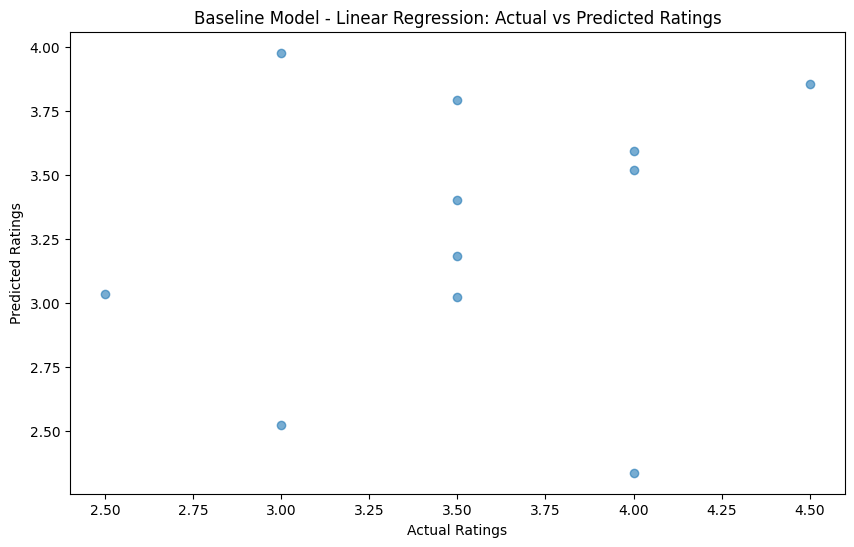

In [233]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Baseline Model - Linear Regression: Actual vs Predicted Ratings')

- Final Model - Gradient Boosting
---

In [234]:
# x-train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Predictions on test set
y_pred = gbr.predict(X_test)

# Evaluate on test set
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gbr = r2_score(y_test, y_pred)

print("🔍 Gradient Boosting on Test Set:")
print(f"Mean Absolute Error:  {mae_gbr:.4f}")
print(f"Root Mean-Square Error: {rmse_gbr:.4f}")
print(f"R²:   {r2_gbr:.4f}")

# Cross-Validation (5-Fold)
cv_mae_gbr = -cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_r2_gbr = cross_val_score(gbr, X, y, cv=5, scoring='r2')
y_pred_cv_gbr = cross_val_predict(gbr, X, y, cv=5)
cv_rmse_gbr = np.sqrt(mean_squared_error(y, y_pred_cv_gbr))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {cv_mae_gbr.mean():.4f} (std: {cv_mae_gbr.std():.4f})")
print(f"Average RMSE: {cv_rmse_gbr:.4f}")
print(f"Average R²:   {cv_r2_gbr.mean():.4f} (std: {cv_r2_gbr.std():.4f})")


🔍 Gradient Boosting on Test Set:
Mean Absolute Error:  0.2958
Root Mean-Square Error: 0.3476
R²:   0.5882

📊 5-Fold Cross-Validation:
Average MAE:  0.4130 (std: 0.0654)
Average RMSE: 0.5349
Average R²:   0.1704 (std: 0.2729)


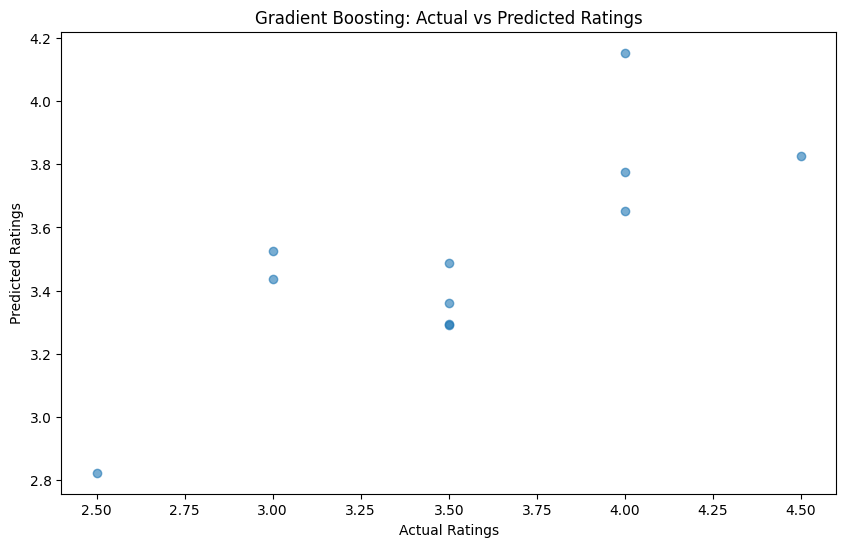

In [235]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Gradient Boosting: Actual vs Predicted Ratings')
plt.show()


In [236]:
# comparing the baseline model to the final model

print('Prediction Model Comparison:')

print("\n🔍 Test Set Evaluation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_mae:.4f} {mae_gbr:>18.4f}")
print(f"{'RMSE':<10} {lr_rmse:.4f} {rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_r2:.4f} {r2_gbr:>18.4f}")

print("\n📊 5-Fold Cross-Validation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_cv_mae.mean():.4f} {cv_mae_gbr.mean():>18.4f}")
print(f"{'RMSE':<10} {lr_cv_rmse:.4f} {cv_rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_cv_r2.mean():.4f} {cv_r2_gbr.mean():>18.4f}")


Prediction Model Comparison:

🔍 Test Set Evaluation:
Metric     Linear Reg     Gradient Boost
MAE        0.5790             0.2958
RMSE       0.7052             0.3476
R²         -0.6949             0.5882

📊 5-Fold Cross-Validation:
Metric     Linear Reg     Gradient Boost
MAE        0.9134             0.4130
RMSE       2.4983             0.5349
R²         -11.0666             0.1704


---
- Classifying business success level (Struggling, Stable, Successful) based on operational and user-related features
    - Baseline Model – Most Frequent Class
    - Final Model – Gradient Boosting Classifier
- Built models to classify business success levels (Struggling, Stable, Successful) based on operational and user-related features; used Most Frequent Class as a baseline and Gradient Boosting Classifier as the primary model.
---

In [237]:
def classify_business(stars):
    if stars < 3.0:
        return 'Struggling'
    elif stars < 4.0:
        return 'Stable'
    else:
        return 'Successful'

business_df['business_status'] = business_df['business_stars'].apply(classify_business)

business_df['business_status'].value_counts()


business_status
Stable        26
Successful    24
Struggling     5
Name: count, dtype: int64

In [238]:
X_class = business_df.drop(columns=['business_stars', 'business_status','business_id'])  # drop target + optional
y_class = business_df['business_status']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)


- Baseline Model – Most Frequent Class
---

In [239]:
# Create and train the baseline model
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train_clf, y_train_clf)

# Predict and evaluate
y_pred_baseline = baseline_clf.predict(X_test_clf)

cv_scores_baseline = cross_val_score(baseline_clf, X_class, y_class,cv=5, scoring='f1_weighted')

print("📉 Baseline Model (Most Frequent Class):\n")
print(classification_report(y_test_clf, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_baseline))

print("📉 Baseline Model - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_baseline)
print("Average F1:", np.mean(cv_scores_baseline))

📉 Baseline Model (Most Frequent Class):

              precision    recall  f1-score   support

      Stable       0.45      1.00      0.62         5
  Struggling       0.00      0.00      0.00         1
  Successful       0.00      0.00      0.00         5

    accuracy                           0.45        11
   macro avg       0.15      0.33      0.21        11
weighted avg       0.21      0.45      0.28        11

Confusion Matrix:
[[5 0 0]
 [1 0 0]
 [5 0 0]]
📉 Baseline Model - 5-Fold CV F1 (weighted):
Scores: [0.38502674 0.28409091 0.28409091 0.28409091 0.28409091]
Average F1: 0.3042780748663102


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

- Final Model – Gradient Boosting Classifier
---

In [240]:
# train the model
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gbc.fit(X_train_clf, y_train_clf)

y_pred_gbc = gbc.predict(X_test_clf)

print("🌟 Gradient Boosting Classifier:\n")
print(classification_report(y_test_clf, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_gbc))

cv_scores_gbc = cross_val_score(gbc, X_class, y_class,cv=5, scoring='f1_weighted')

print("\n🌟 Gradient Boosting Classifier - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_gbc)
print("Average F1:", np.mean(cv_scores_gbc))

🌟 Gradient Boosting Classifier:

              precision    recall  f1-score   support

      Stable       0.50      0.40      0.44         5
  Struggling       0.00      0.00      0.00         1
  Successful       0.67      0.80      0.73         5

    accuracy                           0.55        11
   macro avg       0.39      0.40      0.39        11
weighted avg       0.53      0.55      0.53        11

Confusion Matrix:
[[2 1 2]
 [1 0 0]
 [1 0 4]]

🌟 Gradient Boosting Classifier - 5-Fold CV F1 (weighted):
Scores: [0.73002755 0.78282828 0.34894399 0.55096419 0.60606061]
Average F1: 0.6037649219467401


In [241]:
print("\n📊 5-Fold Cross-Validation Comparison (F1-weighted):")
print(f"{'Model':<25} {'F1 Scores':<40} {'Average F1':>12}")
print("-" * 80)
print(f"{'Baseline (Most Frequent)':<25} {str(cv_scores_baseline.tolist()):<40} {np.mean(cv_scores_baseline):>12.4f}")
print(f"{'Gradient Boosting':<25} {str(cv_scores_gbc.tolist()):<40} {np.mean(cv_scores_gbc):>12.4f}")



📊 5-Fold Cross-Validation Comparison (F1-weighted):
Model                     F1 Scores                                  Average F1
--------------------------------------------------------------------------------
Baseline (Most Frequent)  [0.3850267379679144, 0.2840909090909091, 0.2840909090909091, 0.2840909090909091, 0.2840909090909091]       0.3043
Gradient Boosting         [0.7300275482093664, 0.7828282828282828, 0.34894398530762166, 0.5509641873278237, 0.606060606060606]       0.6038


---
- Forecasting business activity over time (reviews and check-ins) using historical patterns
    - Baseline Model – Naive Forecast
    - Final Model – Time Series Regression (e.g., Gradient Boosting or ARIMA)
- Built models to forecast review volume and check-in frequency for businesses over a 6-month horizon using historical activity data; implemented a Naive Forecast as a baseline and used Gradient Boosting Regressor for advanced time series predictions.
---

In [242]:
## Prep the data for time series analysis

master['review_date'] = pd.to_datetime(master['review_date'], errors='coerce')
master['year_month'] = master['review_date'].dt.to_period('M').astype(str)
reviews_monthly = (master.groupby(['business_id', 'year_month']).size().reset_index(name='review_count'))

checkin_expanded = master[['business_id', 'checkin_dates']].dropna().copy()
checkin_expanded = checkin_expanded.drop_duplicates(subset=['business_id'])

checkin_expanded['checkin_dates'] = checkin_expanded['checkin_dates'].str.split(', ')
checkin_expanded = checkin_expanded.explode('checkin_dates')
checkin_expanded['checkin_datetime'] = pd.to_datetime(checkin_expanded['checkin_dates'], errors='coerce')
checkin_expanded = checkin_expanded.dropna(subset=['checkin_datetime'])
checkin_expanded['year_month'] = checkin_expanded['checkin_datetime'].dt.to_period('M').astype(str)

checkins_monthly = (checkin_expanded.groupby(['business_id', 'year_month']).size().reset_index(name='checkin_count'))

time_series_df = pd.merge(reviews_monthly, checkins_monthly, on=['business_id', 'year_month'], how='outer').fillna(0)

time_series_df['year_month'] = pd.to_datetime(time_series_df['year_month'])
time_series_df = time_series_df.sort_values(['business_id', 'year_month']).reset_index(drop=True)

- Baseline Model – Naive Forecast
---

In [243]:
# Get business with the most monthly data
top_business = time_series_df['business_id'].value_counts().idxmax()

In [244]:
# Filter time series for that business
biz = time_series_df[time_series_df['business_id'] == top_business].copy()
biz['year_month'] = pd.to_datetime(biz['year_month'])
biz = biz.sort_values('year_month')

# stop the data at 2020-01
biz_ts = biz[biz['year_month'] < '2020-01']

In [245]:
# Get the last known month and values
biz_ts['year_month'] = pd.to_datetime(biz_ts['year_month'])
last_month = biz_ts['year_month'].max()
last_reviews = biz_ts.loc[biz_ts['year_month'] == last_month, 'review_count'].values[0]
last_checkins = biz_ts.loc[biz_ts['year_month'] == last_month, 'checkin_count'].values[0]

# Create forecast dates
future_months = pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=24, freq='MS')

# Build the forecast DataFrame
naive_forecast = pd.DataFrame({
    'business_id': top_business,
    'year_month': future_months,
    'review_count_naive': last_reviews,
    'checkin_count_naive': last_checkins
})


/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_66617/3408547640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biz_ts['year_month'] = pd.to_datetime(biz_ts['year_month'])


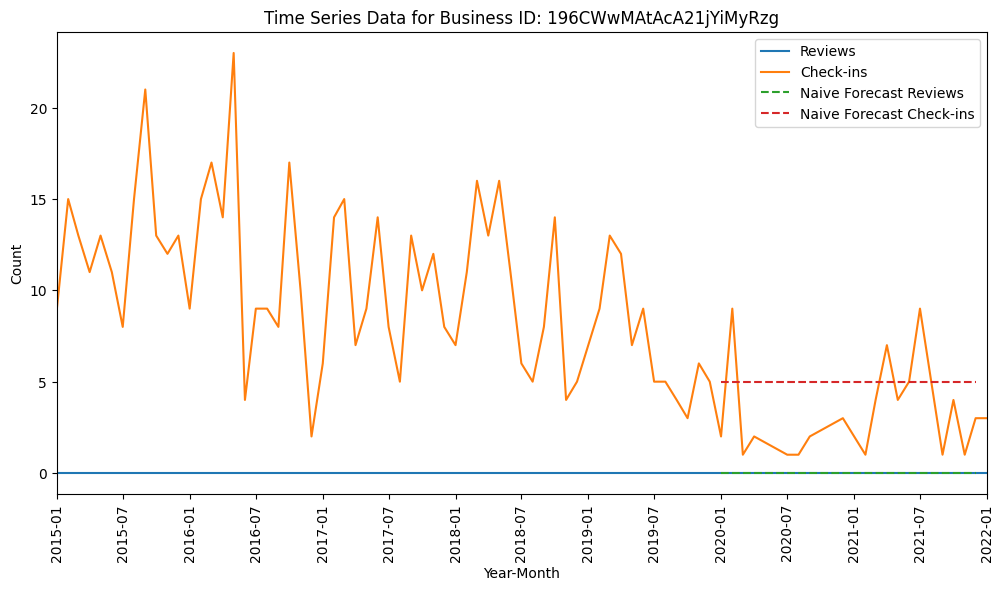

In [246]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(biz['year_month'], biz['review_count'], label='Reviews')
ax.plot(biz['year_month'], biz['checkin_count'], label='Check-ins')
ax.plot(naive_forecast['year_month'], naive_forecast['review_count_naive'], label='Naive Forecast Reviews', linestyle='--')
ax.plot(naive_forecast['year_month'], naive_forecast['checkin_count_naive'], label='Naive Forecast Check-ins', linestyle='--')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count')
ax.set_title(f'Time Series Data for Business ID: {top_business}')
ax.legend()
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2015-01'), pd.to_datetime('2022-01'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # show every 3 months

plt.show()

In [247]:
# Evaluate the naive forecast
# Filter actual review/check-in values for the forecasted 24 months
# Make sure 'biz_ts' is time-indexed with 'year_month' as datetime
actuals = biz.set_index('year_month')

# Get the last 6 known months of actuals (or whatever matches your forecast period)
actual_review_values = actuals['review_count'].iloc[-24:].values
actual_checkin_values = actuals['checkin_count'].iloc[-24:].values

naive_review_forecast = [actual_review_values[-1]] * 24
naive_checkin_forecast = [actual_checkin_values[-1]] * 24

rmse_naive_review = np.sqrt(mean_squared_error(actual_review_values, naive_review_forecast))
rmse_naive_checkin = np.sqrt(mean_squared_error(actual_checkin_values, naive_checkin_forecast))

print(f"📉 RMSE (Naive - Reviews): {rmse_naive_review:.2f}")
print(f"📉 RMSE (Naive - Check-ins): {rmse_naive_checkin:.2f}")



📉 RMSE (Naive - Reviews): 0.00
📉 RMSE (Naive - Check-ins): 2.42


- Final Model – Time Series Regression using Prophet
---

In [248]:
# ---- Prep review data for Prophet ----
review_df = biz_ts[['year_month', 'review_count']].copy()
review_df.columns = ['ds', 'y']

# Fit Prophet model
prophet_review = Prophet()
prophet_review.fit(review_df)

# Forecast next 6 months
future_review = prophet_review.make_future_dataframe(periods=25, freq='MS')
forecast_review = prophet_review.predict(future_review)

# ---- Prep check-in data for Prophet ----
checkin_df = biz_ts[['year_month', 'checkin_count']].copy()
checkin_df.columns = ['ds', 'y']

# Fit Prophet model
prophet_checkin = Prophet()
prophet_checkin.fit(checkin_df)

# Forecast next 6 months
future_checkin = prophet_checkin.make_future_dataframe(periods=25, freq='MS')
forecast_checkin = prophet_checkin.predict(future_checkin)


21:28:21 - cmdstanpy - INFO - Chain [1] start processing
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
21:28:21 - cmdstanpy - INFO - Chain [1] done processing


In [249]:
# Extract forecasted review values from Jan 2020 to Dec 2021
forecast_range_review = forecast_review[(forecast_review['ds'] > '2019-12-01') & (forecast_review['ds'] <= '2022-01-01')].copy()
forecast_range_review = forecast_range_review[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

forecast_range_checkin = forecast_checkin[(forecast_checkin['ds'] > '2019-12-01') & (forecast_checkin['ds'] <= '2022-01-01')].copy()
forecast_range_checkin = forecast_range_checkin[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

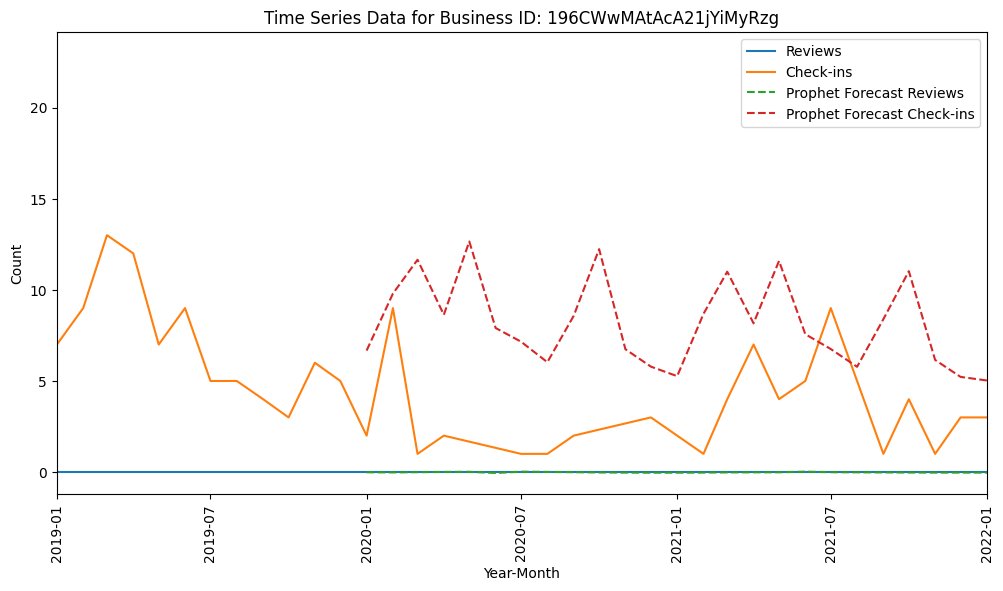

In [250]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(biz['year_month'], biz['review_count'], label='Reviews')
ax.plot(biz['year_month'], biz['checkin_count'], label='Check-ins')
ax.plot(forecast_range_review['ds'], forecast_range_review['yhat'], label='Prophet Forecast Reviews', linestyle='--')
ax.plot(forecast_range_checkin['ds'], forecast_range_checkin['yhat'], label='Prophet Forecast Check-ins', linestyle='--')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count')
ax.set_title(f'Time Series Data for Business ID: {top_business}')
ax.legend()
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2019-01'), pd.to_datetime('2022-01'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # show every 3 months

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# --- Assume you already have: ---
# actual_review: DataFrame with columns ['year_month', 'review_count']
# pred_review: Prophet forecast DataFrame with columns ['ds', 'yhat']

# actual_checkin: DataFrame with columns ['year_month', 'checkin_count']
# pred_checkin: Prophet forecast DataFrame with columns ['ds', 'yhat']

# --- Merge actuals with predictions to make sure they are aligned ---

# Merge review counts
review_merged = pd.merge(
    actual_review, 
    pred_review, 
    left_on='year_month', 
    right_on='ds', 
    how='inner'
)

# Merge check-in counts
checkin_merged = pd.merge(
    actual_checkin, 
    pred_checkin, 
    left_on='year_month', 
    right_on='ds', 
    how='inner'
)

# --- Calculate RMSE properly ---

rmse_review_prophet = np.sqrt(mean_squared_error(review_merged['review_count'], review_merged['yhat']))
rmse_checkin_prophet = np.sqrt(mean_squared_error(checkin_merged['checkin_count'], checkin_merged['yhat']))

# --- Print Results ---
print(f"📊 RMSE (Prophet - Reviews): {rmse_review_prophet:.2f}")
print(f"📊 RMSE (Prophet - Check-ins): {rmse_checkin_prophet:.2f}")


In [251]:
# Evaluate the Prophet forecast
actuals = biz[biz['year_month'] >= '2020-01']

actual_review = actuals[['year_month', 'review_count']].reset_index(drop=True)
pred_review = forecast_range_review[['ds', 'yhat']].reset_index(drop=True)

actual_checkin = actuals[['year_month', 'checkin_count']].reset_index(drop=True)
pred_checkin = forecast_range_checkin[['ds', 'yhat']].reset_index(drop=True)

rmse_review_prophet = np.sqrt(mean_squared_error(actual_review['review_count'], pred_review['yhat']))
rmse_checkin_prophet = np.sqrt(mean_squared_error(actual_checkin['checkin_count'], pred_checkin['yhat']))

print(f"📊 RMSE (Prophet - Check-ins): {rmse_checkin_prophet:.2f}")
print(f"📊 RMSE (Prophet - Reviews): {rmse_review_prophet:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [21, 25]

In [252]:
# comparing the naive forecast to the prophet forecast
print("\n📊 RMSE Comparison:")
print(f"{'Model':<18} {'Reviews RMSE':<15} {'Check-ins RMSE':<20}")
print("-" * 65)
print(f"{'Naive Forecast':<20} {rmse_naive_review:.2f}             {rmse_naive_checkin:.2f}")
print(f"{'Prophet Forecast':<20} {rmse_review_prophet:.2f}             {rmse_checkin_prophet:.2f}")



📊 RMSE Comparison:
Model              Reviews RMSE    Check-ins RMSE      
-----------------------------------------------------------------
Naive Forecast       0.00             2.42


NameError: name 'rmse_review_prophet' is not defined